# Predicting Log Error


## Goal:

- Identify any features that are driving the difference in Zestimate and sales prices for single unit properties which creates a log error 


- Construct a model to predict the targeted log error.

## Result:

- The created model can predict .004 of the variance in log error and is statiscally significant.

## Method:

In [1]:
# Import statements

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import scipy.stats as stats
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer,RobustScaler,MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LogisticRegression
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from math import sqrt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import env
import get_function as gf

## Acquire

- The focus of which property type to acquire was on single units only. 

- A single unit property is defined as a standalone property built for one family. If a structure includes more than one collection of living spaces with separate entrances and privacy, it is not included as a single unit property.

In [2]:
# Acquire data from zillow database

df = gf.get_zillow_data()

In [3]:
df.head()

parcelid  logerror transactiondate       id  parcelid  \
0  12177905 -0.103410      2017-01-01  2288172  12177905   
1  12095076 -0.001011      2017-01-01   781532  12095076   
2  12069064  0.101723      2017-01-01   870991  12069064   
3  12790562 -0.040966      2017-01-02  1246926  12790562   
4  11104527  0.005963      2017-01-02  1639362  11104527   

   airconditioningtypeid architecturalstyletypeid basementsqft  bathroomcnt  \
0                    NaN                     None         None          3.0   
1                    1.0                     None         None          3.0   
2                    NaN                     None         None          1.0   
3                    NaN                     None         None          3.0   
4                    1.0                     None         None          3.0   

   bedroomcnt  ... numberofstories  fireplaceflag  structuretaxvaluedollarcnt  \
0         4.0  ...             NaN           None                    108918.0   
1         4.0  ...             NaN           None                    276684.0   
2         2.0  ...             NaN           None                     18890.0   
3         4.0  ...             NaN           None                    177527.0   
4         4.0  ...             NaN           None                    271715.0   

  taxvaluedollarcnt assessmentyear  landtaxvaluedollarcnt  taxamount  \
0          145143.0         2016.0                36225.0    1777.51   
1          773303.0         2016.0               496619.0    9516.26   
2          218552.0         2016.0               199662.0    2366.08   
3          220583.0         2016.0                43056.0    3104.19   
4          430108.0         2016.0               158393.0    6103.36   

  taxdelinquencyflag taxdelinquencyyear censustractandblock  
0               None                NaN        6.037300e+13  
1               None                NaN        6.037461e+13  
2               None                NaN        6.037302e+13  
3               None                NaN        6.037500e+13  
4               None                NaN        6.037920e+13  

[5 rows x 62 columns]

## Prepare

- Reducing the number of columns and rows based on limited value added

In [4]:
# drop columns with more than 60% of data as null as well as rows with more than 75% of data as null

df = gf.handle_missing_values(df, prop_required_column = .6, prop_required_row = .75)

In [5]:
# removing unnessesery columns

df = gf.remove_columns(df, ['roomcnt','assessmentyear','unitcnt','regionidzip','regionidcounty','propertylandusetypeid','propertycountylandusecode','fullbathcnt','calculatedbathnbr','rawcensustractandblock','finishedsquarefeet12','parcelid','transactiondate','id','regionidcity','buildingqualitytypeid','heatingorsystemtypeid','propertyzoningdesc','censustractandblock'])

In [6]:
df = df.rename(columns={'lotsizesquarefeet':'lot_square_feet','calculatedfinishedsquarefeet':'home_square_feet', 'logerror': 'target','bathroomcnt': 'bathroom', 'bedroomcnt': 'bedroom','structuretaxvaluedollarcnt':'structure_value','taxvaluedollarcnt': 'total_value','landtaxvaluedollarcnt':'land_value','taxamoun':'tax_amount','taxamount':'tax_amount','yearbuilt':'year_built'})

In [7]:
# Covert year_built column into age in years enhancing data visualizations

df['age']= 2017 - df.year_built

# Drop year built because we added age column

df.drop(columns='year_built',inplace=True)

In [8]:
# Split data (train & test)

train, test = gf.split_my_data(df, .80, 123)

In [9]:
# impute lot_square_feet,structure_value, and tax_amount for the mean

train = gf.imputer_9000(train,['lot_square_feet','structure_value','tax_amount', 'age'],'mean')
test = gf.imputer_9000(test,['lot_square_feet','structure_value','tax_amount', 'age'],'mean')

In [10]:
train['home_value_square_footage'] = train.structure_value/train.home_square_feet
train['land_value_square_footage'] = train.land_value/train.lot_square_feet

test['home_value_square_footage'] = test.structure_value/test.home_square_feet
test['land_value_square_footage'] = test.land_value/test.lot_square_feet

In [11]:
train.isnull().sum()

target                       0
bathroom                     0
bedroom                      0
home_square_feet             0
fips                         0
latitude                     0
longitude                    0
lot_square_feet              0
structure_value              0
total_value                  0
land_value                   0
tax_amount                   0
age                          0
home_value_square_footage    0
land_value_square_footage    0
dtype: int64

In [12]:
test.isnull().sum()

target                       0
bathroom                     0
bedroom                      0
home_square_feet             0
fips                         0
latitude                     0
longitude                    0
lot_square_feet              0
structure_value              0
total_value                  0
land_value                   0
tax_amount                   0
age                          0
home_value_square_footage    0
land_value_square_footage    0
dtype: int64

In [13]:
# Scale age, latitude, and longitude using MinMax scaler - why (to presrve distance better, and not distort correlation)

train = gf.scaler_min_max(train, ['age', 'latitude', 'longitude', 'land_value_square_footage', 'home_value_square_footage'])
test = gf.scaler_min_max(test, ['age', 'latitude', 'longitude', 'land_value_square_footage', 'home_value_square_footage'])

In [14]:
# Scale bathroom, bedroom, home_square_feet, lot_square_feet, structure_value, total_value, land_value, tax_amount using uniform scaler

# Scale columns using Uniform scaler (to smooth out the distribution and handle outliers)

train = gf.uniform_scaler(train,['bathroom', 'bedroom', 'home_square_feet', 'lot_square_feet', 'structure_value', 'total_value', 'land_value', 'tax_amount'])
test = gf.uniform_scaler(test,['bathroom', 'bedroom', 'home_square_feet', 'lot_square_feet', 'structure_value', 'total_value', 'land_value', 'tax_amount'])

In [15]:
train.head()

target    fips       age  latitude  longitude  \
27330  0.002157  6037.0  0.395522  0.557000   0.285832   
12260 -0.053258  6037.0  0.462687  0.359512   0.402151   
27165 -0.027946  6037.0  0.044776  0.889853   0.516559   
27296  0.036370  6037.0  0.664179  0.514136   0.517688   
6387  -0.000858  6037.0  0.238806  0.353049   0.413865   

       land_value_square_footage  home_value_square_footage  bathroom  \
27330                   0.017275                   0.058223  0.474747   
12260                   0.004009                   0.014283  0.474747   
27165                   0.000881                   0.011971  0.808081   
27296                   0.055174                   0.094028  0.000000   
6387                    0.073855                   0.072092  0.808081   

        bedroom  home_square_feet  lot_square_feet  structure_value  \
27330  0.439394          0.873672         0.839560         0.795914   
12260  0.439394          0.545455         0.119727         0.070707   
27165  0.439394          0.749439         0.767824         0.084252   
27296  0.111111          0.014805         0.009555         0.375978   
6387   0.439394          0.728758         0.010566         0.770683   

       total_value  land_value  tax_amount  
27330     0.866593    0.879433    0.863241  
12260     0.132333    0.257921    0.116210  
27165     0.060612    0.092274    0.570231  
27296     0.699622    0.776588    0.676910  
6387      0.848893    0.865827    0.841041

**Exploration**

- Analysis, correlation, visualization

In [16]:
# Exploring overestimits versus underestimits

In [17]:
# mean of all overestimits
train.target[train.target > 0].mean()

0.081850353460498

In [18]:
# mean of all underestimits
train.target[train.target < 0].mean()

-0.06776640057920577

In [19]:
train.target[train.target > 0].count() /(train.target[train.target > 0].count() + train.target[train.target < 0].count())

0.5522626112759644

Differinces in over and underestimation

over mean = .081

over %56

under mean = -.068

under %44

In [20]:
# Added to look for corrilation between variables and total log error irrespective of over or under estimation

train['absolute_target']= train.target.abs() 

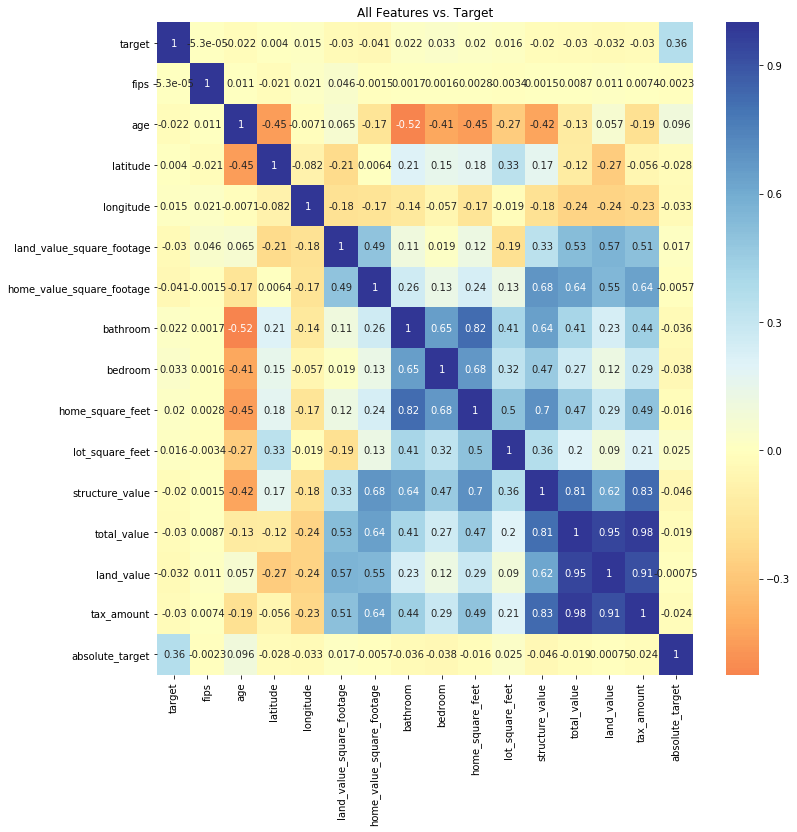

In [21]:
#heatmap for correlation

plt.figure(figsize=(12,12))
plt.title('All Features vs. Target')
sns.heatmap(train.corr(), cmap='RdYlBu', annot=True, center=0)

<Figure size 1584x1584 with 0 Axes>

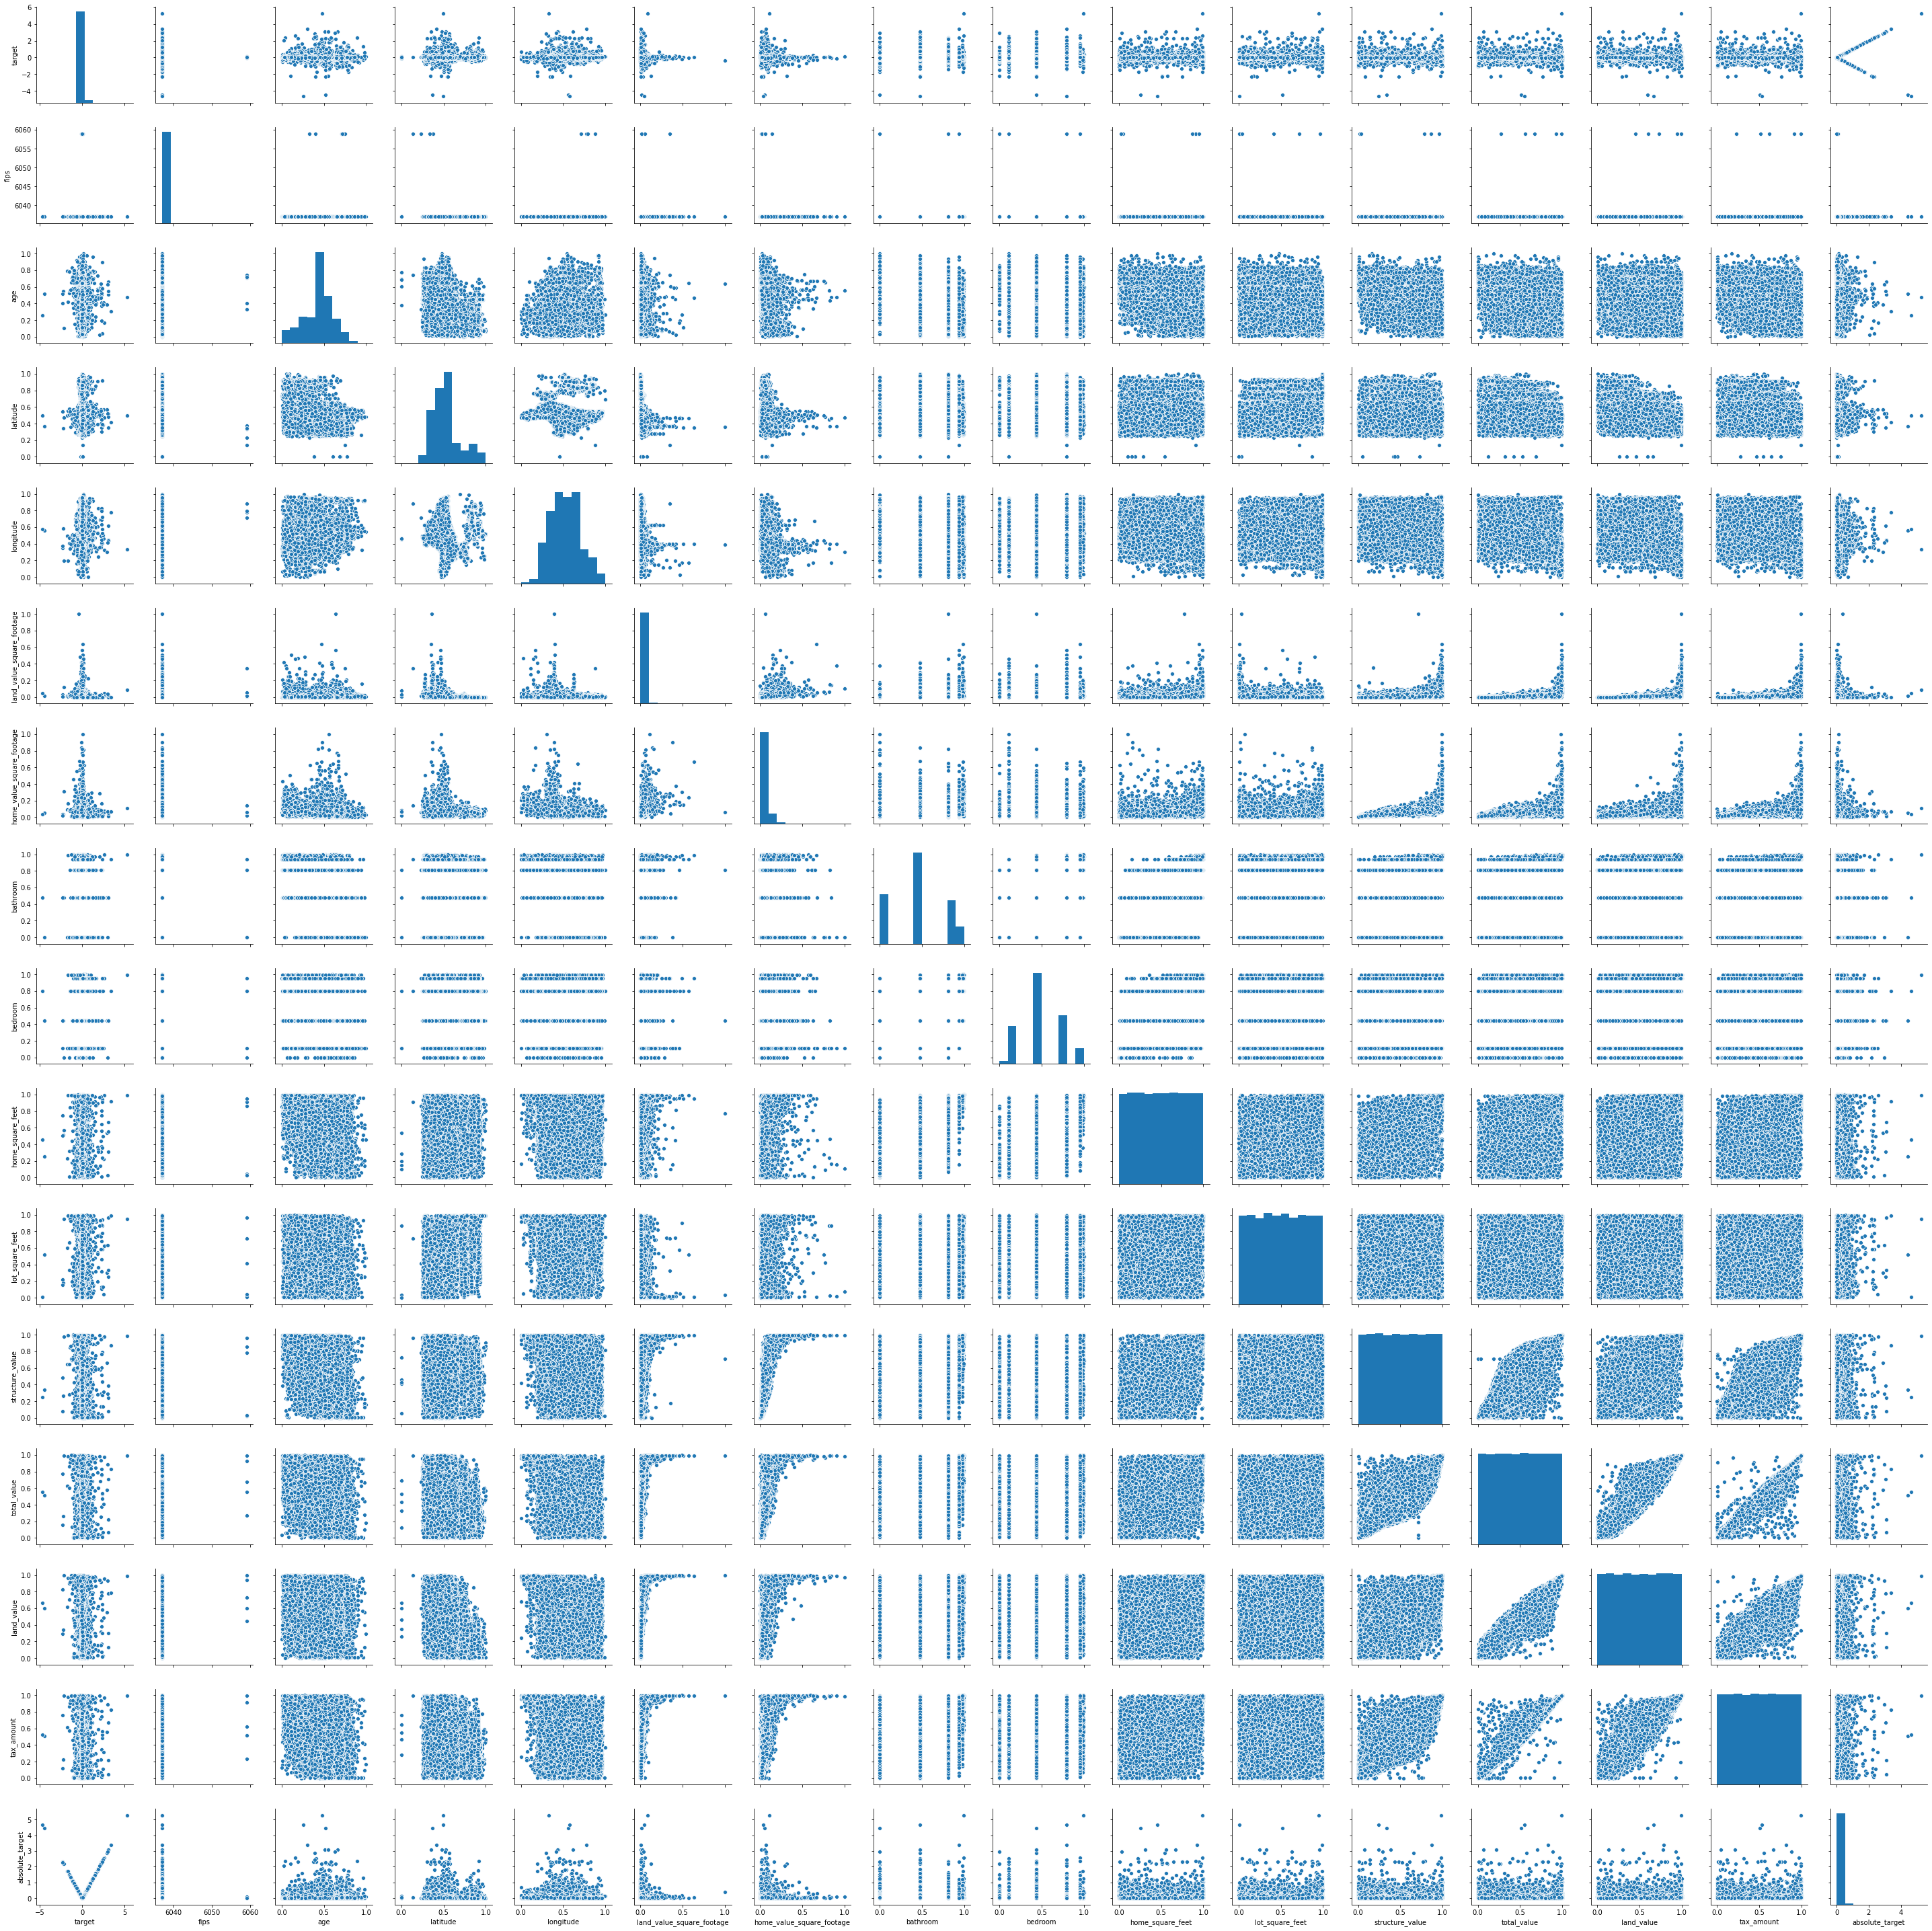

In [22]:
plt.figure(figsize=(22,22))
sns.pairplot(train)
plt.show()

<Figure size 1584x1584 with 0 Axes>

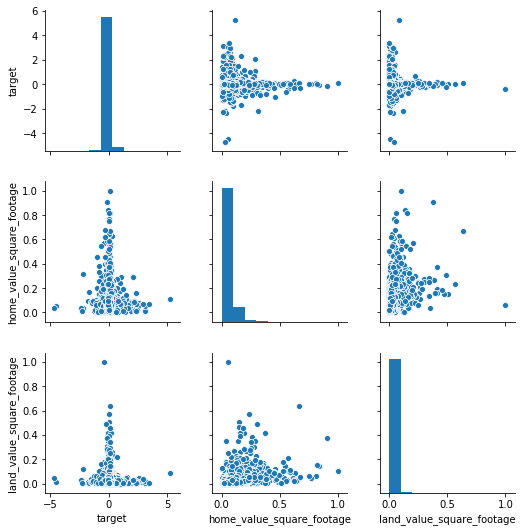

In [23]:
# home_value_square_footage and land_value_square_footage showed the most potential for explaning the targe 

plt.figure(figsize=(22,22))
sns.pairplot(train[['target', 'home_value_square_footage','land_value_square_footage']])

plt.show()

**Note:** home_value_square_footage and land_value_square_foortage show a relationship with logerror

**Task:** drop multiple columns after exploring 

In [24]:
# dropped column because of little value added

train.drop(columns='absolute_target',inplace=True)

In [25]:
# dropping columns due to interfernce based on the model interpreting the values not as discrete but rather as continious values.

train = train.drop(columns=['fips','latitude','longitude'])

## Modeling:

### Baseline Model

- Use target mean to predict target
- Use all acquired features to predict target
- Evaluate based Sum of Squared Errors, Mean of Squared Errors, and Root Mean of Squared Errors

In [26]:
# Create new column to perform a baseline model using the target's mean value

train['y_base']= train.target.mean()

In [27]:
# Baseline using target mean

x = train[['y_base']]
y = train[['target']]

regr = ols('y ~ x', data = train).fit()

train['yhat'] = regr.predict(x)

SSE, MSE, RMSE = gf.regression_errors(y,train.yhat, train)

train.drop(columns=['yhat','y_base'],inplace=True)

SSE:  773.667932212638 MSE:  0.028696881758629007 RMSE:  0.16940154001256602


In [28]:
# Baseline using beginning acquired features

x = train.drop(columns=['land_value_square_footage','home_value_square_footage','target'])
y = train[['target']]

regr = ols('y ~ x', data = train).fit()

train['yhat'] = regr.predict(x)

SSE, MSE, RMSE = gf.regression_errors(y,train.yhat, train)

train.drop(columns='yhat',inplace=True)

SSE:  770.6964631078371 MSE:  0.028586664061863394 RMSE:  0.16907591212784687


### Clustering

- Use K-Means
- Use Elbow Method to determine optimal 'K'

   k        sse
0  1  67.033946
1  2  39.766073
2  3  26.500678
3  4  20.081605
4  5  16.139411
5  6  13.526434
6  7  11.469923
7  8   9.957567
8  9   8.667633


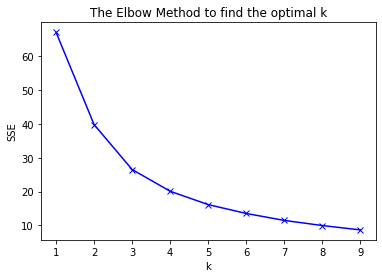

In [29]:
# Clustering feature engineered columns only

ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(train[['home_value_square_footage','land_value_square_footage']])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method to find the optimal k')
plt.show()

**Note:** The elbow visualization provides possible values for K, 4 - 6

**Task:** Create the instance of the k-means class, fit it to the data, then use the object to make predictions

### K = 5

In [30]:
# List of engineered features to cluster
cluster_columns = ['home_value_square_footage', 'land_value_square_footage']

# Make the clusters
kmeans = KMeans(n_clusters=5, n_init =1, random_state=123).fit(train[cluster_columns])

# Add clusters back to dataframe
train['cluster'] = kmeans.predict(train[cluster_columns])

# Find average of the cluster columns
cluster_means = train.groupby('cluster')[cluster_columns].transform('mean')

# Rename columns
cluster_means.columns = ['avg_home_value_square_footage', 'avg_land_value_square_footage']

# Rejoin original dataframe
train = train.join(cluster_means)

In [31]:
# Create model using only cluster variables

x = train[['avg_home_value_square_footage', 'avg_land_value_square_footage']]
y = train[['target']]

regr = ols('y ~ x', data = train).fit()

train['yhat'] = regr.predict(x)

SSE, MSE, RMSE = gf.regression_errors(y,train.yhat, train)

train.drop(columns='yhat',inplace=True)

SSE:  772.2939020370583 MSE:  0.028645916247665368 RMSE:  0.16925104504157534


In [32]:
# Create model using all features excluding those columns used to create clusters

x = train.drop(columns = ['home_value_square_footage', 'land_value_square_footage', 'target','cluster','land_value','structure_value','home_square_feet','lot_square_feet'])
y = train[['target']]

regr = ols('y ~ x', data = train).fit()

train['yhat'] = regr.predict(x)

SSE, MSE, RMSE = gf.regression_errors(y,train.yhat, train)

train.drop(columns='yhat',inplace=True)

SSE:  770.7296412142879 MSE:  0.02858789470379406 RMSE:  0.1690795514064136


**Note:** The last model seems to be the best path forward. Dropping the columns which help create the cluster columns provides an improvement. Now we will try with different values for K, 4 and 6.

In [33]:
# Resetting train data set for a new test of k = 4

train.drop(columns=['cluster','avg_home_value_square_footage','avg_land_value_square_footage'],inplace=True)

### K = 4

In [34]:
# List of engineered features to cluster
cluster_columns = ['home_value_square_footage', 'land_value_square_footage']

# Make the clusters
kmeans = KMeans(n_clusters= 4, n_init =1, random_state=123).fit(train[cluster_columns])

# Add clusters back to dataframe
train['cluster'] = kmeans.predict(train[cluster_columns])

# Find average of the cluster columns
cluster_means = train.groupby('cluster')[cluster_columns].transform('mean')

# Rename columns
cluster_means.columns = ['avg_home_value_square_footage', 'avg_land_value_square_footage']

# Rejoin original dataframe
train = train.join(cluster_means)

In [35]:
# Create model using all features excluding those columns used to create clusters

x = train.drop(columns = ['home_value_square_footage', 'land_value_square_footage','target','cluster','land_value','structure_value','home_square_feet','lot_square_feet'])
y = train[['target']]

regr = ols('y ~ x', data = train).fit()

train['yhat'] = regr.predict(x)

SSE, MSE, RMSE = gf.regression_errors(y,train.yhat, train)

train.drop(columns='yhat',inplace=True)

SSE:  770.8127802403343 MSE:  0.028590978495561362 RMSE:  0.16908867051213503


In [36]:
# Resetting train data set for a new test of k = 6

train.drop(columns=['cluster','avg_home_value_square_footage','avg_land_value_square_footage'],inplace=True)

## K = 6

In [37]:
# List of engineered features to cluster
cluster_columns = ['home_value_square_footage', 'land_value_square_footage']

# Make the clusters
kmeans = KMeans(n_clusters= 6, n_init =1, random_state=123).fit(train[cluster_columns])

# Add clusters back to dataframe
train['cluster'] = kmeans.predict(train[cluster_columns])

# Find average of the cluster columns
cluster_means = train.groupby('cluster')[cluster_columns].transform('mean')

# Rename columns
cluster_means.columns = ['avg_home_value_square_footage', 'avg_land_value_square_footage']

# Rejoin original dataframe
train = train.join(cluster_means)

In [38]:
# Create model using all features excluding those columns used to create clusters

x = train.drop(columns = ['home_value_square_footage', 'land_value_square_footage', 'target','cluster','land_value','structure_value','home_square_feet','lot_square_feet'])
y = train[['target']]

regr = ols('y ~ x', data = train).fit()

train['yhat'] = regr.predict(x)

SSE, MSE, RMSE = gf.regression_errors(y,train.yhat, train)

train.drop(columns='yhat',inplace=True)

SSE:  770.6959996475189 MSE:  0.02858664687119877 RMSE:  0.16907586129071994


**Note:** Overall K = 6 results are marginally better, proceed with final model using the test data set

**Task:** Ensure current state of the test data set matches the column structure of the train data from all the testing above.

## Final Model

- Use test data in OLS model that uses cluster generated features inplace of all features which were used in the creation of those features

In [39]:
# Transform test dataframe to match columns in train data set
test.drop(columns= ['fips', 'latitude', 'longitude'], inplace=True)

In [40]:
# List of engineered features to cluster
cluster_columns = ['home_value_square_footage', 'land_value_square_footage']

# Make the clusters
kmeans = KMeans(n_clusters= 6, n_init =1, random_state=123).fit(test[cluster_columns])

# Add clusters back to dataframe
test['cluster'] = kmeans.predict(test[cluster_columns])

# Find average of the cluster columns
cluster_means = test.groupby('cluster')[cluster_columns].transform('mean')

# Rename columns
cluster_means.columns = ['avg_home_value_square_footage', 'avg_land_value_square_footage']

# Rejoin original dataframe
test = test.join(cluster_means)


In [41]:
# Create model using all features excluding those columns used to create clusters

x = train.drop(columns = ['home_value_square_footage', 'land_value_square_footage', 'target','cluster','land_value','structure_value','home_square_feet','lot_square_feet'])
y = train[['target']]

regr = ols('y ~ x', data = train).fit()

train['yhat'] = regr.predict(x)

SSE, MSE, RMSE = gf.regression_errors(y,train.yhat, train)

train.drop(columns='yhat',inplace=True)

SSE:  770.6959996475189 MSE:  0.02858664687119877 RMSE:  0.16907586129071994


## Comparing Evaluation Metrics:

1. Baseline_target_mean = RMSE: 0.1694015


2. Baseline_acquired_variables = RMSE:0.1690759


3. Clustering_K5_engineered = RMSE: 0.1692510


4. Clustering_K5_cluster_variables = RMSE: 0.1690795


5. Clustering_K4__cluster_variables = RMSE:0.1690886


6. ***Clustering_K6__cluster_variables = RMSE: 0.1690758***


7. ***Clustering_test_K6_cluster_variables = RMSE: 0.1690758***

In [42]:
# Model statistics:

regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     14.85
Date:                Sun, 10 Nov 2019   Prob (F-statistic):           1.82e-19
Time:                        16:47:36   Log-Likelihood:                 9664.3
No. Observations:               26960   AIC:                        -1.931e+04
Df Residuals:                   26952   BIC:                        -1.925e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0232      0.005      4.615      0.000       0.013       0.033
x[0]          -0.0113      0.007     -1.534      0.125      -0.026       0.003
x[1]           0.0096      0.005      1.939      0.052      -0.000       0.019
x[2]           0.0177      0.005      3.482      0.000       0.008       0.028
x[3]           0.0146      0.019      0.786      0.432      -0.022       0.051
x[4]          -0.0291      0.019     -1.559      0.119      -0.066       0.007
x[5]          -0.1589      0.041     -3.881      0.000      -0.239      -0.079
x[6]           0.0368      0.092      0.398      0.691      -0.144       0.218
==============================================================================
Omnibus:                    24154.616   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         21688955.770
Skew:                           3.213   Prob(JB):                         0.00
Kurtosis:                     141.803   Cond. No.                         141.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Takeaways:
